In [5]:
import json
import pandas as pd
import baycon.bayesian_generator as baycon
import baycon.time_measurement as time_measurement
from common.DataAnalyzer import *
from common.Target import Target
# exit from the current folder
import os
import sys
sys.path.append(os.path.join(os.path.dirname("utils.py"), '..'))
import utils
import torch 

In [6]:
data_type = "random"

# get the pretrained centralized models
model1 = utils.Predictor()
model1.load_state_dict(torch.load(f"../checkpoints_predictor/{data_type}/centralized_predictor_client_1.pth"))
model2 = utils.Predictor()
model2.load_state_dict(torch.load(f"../checkpoints_predictor/{data_type}/centralized_predictor_client_2.pth"))
model3 = utils.Predictor()
model3.load_state_dict(torch.load(f"../checkpoints_predictor/{data_type}/centralized_predictor_client_3.pth"))






FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints_predictor/random/centralized_predictor_client_1.pth'

In [3]:
# get best federated global model
# load json file
with open(f'../histories_predictor/server_{data_type}/metrics_1000.json') as json_file:
    data = json.load(json_file)

# take the min loss model
epoch = data['loss'].index(min(data['loss'])) + 1
print(f"Best model at epoch {epoch}")
model_global = utils.Predictor()
model_global.load_state_dict(torch.load(f"../checkpoints_predictor/{data_type}/model_round_{epoch}.pth"))



Best model at epoch 1000


<All keys matched successfully>

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def load_data(client_id="1",device="cpu", type='random'):
    # load data
    #df_train = pd.read_csv('data/df_split_random2.csv')
    df_train = pd.read_csv(f'data/df_split_{type}_{client_id}.csv')
    df_train = df_train.astype(int)
    # Dataset split
    X = df_train.drop('Diabetes_binary', axis=1)
    y = df_train['Diabetes_binary']
    # Use 10 % of total data as Test set and the rest as (Train + Validation) set 
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.001) # use only 0.1% of the data as test set - i dont perform validation on client test set
    # Use 20 % of (Train + Validation) set as Validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)
    num_examples = {'trainset':len(X_train), 'valset':len(X_val), 'testset':len(X_test)}

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train.values)
    X_val = scaler.transform(X_val.values)
    X_train = torch.Tensor(X_train).float().to(device)
    X_val = torch.Tensor(X_val).float().to(device)
    y_train = torch.LongTensor(y_train.values).to(device)
    y_val = torch.LongTensor(y_val.values).to(device)
    return X_train, y_train, X_val, y_val, X_test, y_test, num_examples, scaler

In [5]:
t = Target(target_type="classification", target_feature="Diabetes_binary", target_value=1)

# find all the binary features
df_test = pd.read_csv(f"../data/df_test_{"random"}.csv").astype(int)

binary_features = []
for feature in df_test.keys():
    if df_test[feature].nunique() == 2:
        binary_features.append(feature)


def prepare_model_and_data(target, categorical_features, client_id=1, data_type='random', best_epoch=1000):
    # load data
    df_test = pd.read_csv(f"../data/df_test_{data_type}.csv").astype(int)
    # Dataset split
    X = df_test.drop('Diabetes_binary', axis=1).values
    y = df_test['Diabetes_binary'].values.ravel()
    # encode categorical features
    if categorical_features:
        X = encode(X, categorical_features)
    # load model
    if client_id == "server":
        model_filename = f"../checkpoints_predictor/{data_type}/model_round_{best_epoch}.pth"
    else:
        model_filename = f"../checkpoints_predictor/{data_type}/centralized_predictor_client_{client_id}.pth"
    try:
        print("Checking if {} exists, loading...".format(model_filename))
        model = utils.Predictor()
        model.load_state_dict(torch.load(model_filename))
        print("Loaded model")
    except FileNotFoundError:
        print("Not found, You need to train the model to explain")
         
    feature_names = df_test.columns[df_test.columns != target.target_feature()]
    return model, X, y, feature_names

model, X, y, feature_names = prepare_model_and_data(t, categorical_features=binary_features, client_id="server", data_type='random', best_epoch=1000)

Checking if ../checkpoints_predictor/random/model_round_1000.pth exists, loading...
Loaded model


In [8]:
from tqdm import tqdm

def execute(model, X, Y, feature_names, dataset_name, target, initial_instance_index, categorical_features=[], actionable_features=[], client_id="server", data_type="random", best_epoch=1000):
    run = 0
    model_name = "NN"
    data_analyzer = DataAnalyzer(X, Y, feature_names, target, categorical_features, actionable_features)
    X, Y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = Y[initial_instance_index]
    if False:
        print("--- Executing: {} Initial Instance: {} Target: {} Model: {} Run: {} ---".format(
            dataset_name,
            initial_instance_index,
            target.target_value_as_string(),
            model_name,
            run
        ))
    counterfactuals, ranker, best_instance = baycon.run(initial_instance, initial_prediction, target, data_analyzer, model)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
                                                      target.target_value_as_string(), model_name, run)
    if False:
        with open(output_filename, 'w') as outfile:
            json.dump(output, outfile)
        print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model, best_instance



binary_features = ['Diabetes_binary','HighBP','HighChol','CholCheck','Smoker','Stroke','HeartDiseaseorAttack',
 'PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','DiffWalk','Sex']
client_list = [1, 2, 3, "server"]
data_type = "random"
best_epoch = 2000  # for the server model
size_factor = 0.2

for client_id in client_list:
    print("\033[94m" + f"Client {client_id}" + "\033[0m")
    model, X, Y, feature_names = prepare_model_and_data(t, binary_features, client_id, data_type, best_epoch)
    X = X[:int(len(X) * size_factor)]
    Y = Y[:int(len(Y) * size_factor)]
    best_counterfactuals = list()
    print("Explaining {} instances".format(len(X)))
    for i in tqdm(range(len(X))):
        counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model, best_instance = execute(
            model, X, Y, feature_names,
            dataset_name="diabetes_random_client_1",
            target=t,
            initial_instance_index=i,
            categorical_features=binary_features,
            actionable_features=[],
            client_id=client_id,
            data_type=data_type,
            best_epoch=best_epoch
        )
        best_counterfactuals.append(best_instance)

        if i==5:
            break
    print("Saving best counterfactuals")
    np.save(f"best_counterfactuals_client_{data_type}_{client_id}.npy", np.array(best_counterfactuals))
    preds = model.predict(torch.tensor(np.array(best_counterfactuals))).numpy()
    np.save(f"related_predictions_client_{data_type}_{client_id}.npy", preds)





Client 1


NameError: name 't' is not defined

In [19]:
! cd ..
! pwd


/Users/gabri/Downloads/baycon


In [16]:
import json
import pandas as pd
import baycon.bayesian_generator as baycon
import baycon.time_measurement as time_measurement
from common.DataAnalyzer import *
from common.Target import Target
import torch 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# exit from the current folder
import os
import sys
sys.path.append(os.path.join(os.path.dirname("utils.py"), '..'))
import utils

def load_data(client_id="1",device="cpu", type='random'):
    # load data
    #df_train = pd.read_csv('data/df_split_random2.csv')
    df_train = pd.read_csv(f'../data/df_split_{type}_{client_id}.csv')
    df_train = df_train.astype(int)
    # Dataset split
    X = df_train.drop('Diabetes_binary', axis=1)
    y = df_train['Diabetes_binary']
    # Use 10 % of total data as Test set and the rest as (Train + Validation) set 
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.001) # use only 0.1% of the data as test set - i dont perform validation on client test set
    # Use 20 % of (Train + Validation) set as Validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)
    num_examples = {'trainset':len(X_train), 'valset':len(X_val), 'testset':len(X_test)}

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train.values)
    X_val = scaler.transform(X_val.values)
    X_train = torch.Tensor(X_train).float().to(device)
    X_val = torch.Tensor(X_val).float().to(device)
    y_train = torch.LongTensor(y_train.values).to(device)
    y_val = torch.LongTensor(y_val.values).to(device)
    return X_train, y_train, X_val, y_val, X_test, y_test, num_examples, scaler

# def load_data(client_id="1",device="cpu", type='random'):
#     # load data
#     #df_train = pd.read_csv('data/df_split_random2.csv')
#     df_train = pd.read_csv(f'../data/df_split_{type}_{client_id}.csv')
#     df_train = df_train.astype(int)
#     # Dataset split
#     X = df_train.drop('Diabetes_binary', axis=1)
#     y = df_train['Diabetes_binary']
#     # Use 10 % of total data as Test set and the rest as (Train + Validation) set 
#     X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.001) # use only 0.1% of the data as test set - i dont perform validation on client test set
#     # Use 20 % of (Train + Validation) set as Validation set
#     X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)
#     num_examples = {'trainset':len(X_train), 'valset':len(X_val), 'testset':len(X_test)}

#     scaler = MinMaxScaler()
#     X_train = scaler.fit_transform(X_train.values)
#     X_val = scaler.transform(X_val.values)
#     X_train = torch.Tensor(X_train).float().to(device)
#     X_val = torch.Tensor(X_val).float().to(device)
#     y_train = torch.LongTensor(y_train.values).to(device)
#     y_val = torch.LongTensor(y_val.values).to(device)
#     return X_train, y_train, X_val, y_val, X_test, y_test, num_examples, scaler

# Prepare model and data
def prepare_model_and_data(categorical_features, client_id=1, data_type='random', best_epoch=2000, target_feature="Diabetes_binary"):
    # load data train 
    if client_id == "server":
        X_train1, y_train1, _, _, _, _, _, _ = load_data(client_id=1,device="cpu", type=data_type)
        X_train2, y_train2, _, _, _, _, _, _ = load_data(client_id=2,device="cpu", type=data_type)
        X_train3, y_train3, _, _, _, _, _, scaler = load_data(client_id=3,device="cpu", type=data_type)
        X_train = torch.cat((X_train1, X_train2, X_train3), 0)
        y_train = torch.cat((y_train1, y_train2, y_train3), 0)
    else:
        X_train, y_train, _, _, _, _, _, scaler = load_data(client_id=client_id,device="cpu", type=data_type)
    # load data test
    df_test = pd.read_csv(f"../data/df_test_{data_type}.csv").astype(int)
    # Dataset split
    X = df_test.drop('Diabetes_binary', axis=1).values
    y_test = df_test['Diabetes_binary'].values.ravel()

    # scale data
    X_test = scaler.transform(X)

    # to numpy
    X_train = X_train.numpy()
    y_train = y_train.numpy()

    # encode categorical features
    if categorical_features:
        X_test = encode(X_test, categorical_features)
        X_train = encode(X_train, categorical_features)
    # load model
    if client_id == "server":
        model_filename = f"../checkpoints_predictor/{data_type}/model_round_{best_epoch}.pth"
    else:
        model_filename = f"../checkpoints_predictor/{data_type}/centralized_predictor_client_{client_id}.pth"
    try:
        print("Checking if {} exists, loading...".format(model_filename))
        model = utils.Predictor()
        model.load_state_dict(torch.load(model_filename))
        print("Loaded model")
    except FileNotFoundError:
        print("Not found, You need to train the model to explain")
         
    feature_names = df_test.columns[df_test.columns != target_feature]
    return model, X_train, y_train, X_test, y_test, feature_names, scaler

# Execute baycon
def execute(model, X_train, y_train, X_test, y_test, feature_names, dataset_name, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    run = 0
    model_name = "NN"
    data_analyzer = DataAnalyzer(X_train, y_train, feature_names, target, categorical_features, actionable_features)
    #X, Y = data_analyzer.data()
    initial_instance = X_test[initial_instance_index]
    initial_prediction = y_test[initial_instance_index]
    if False:
        print("--- Executing: {} Initial Instance: {} Target: {} Model: {} Run: {} ---".format(
            dataset_name,
            initial_instance_index,
            target.target_value_as_string(),
            model_name,
            run
        ))
    counterfactuals, ranker, best_instance = baycon.run(initial_instance, initial_prediction, target, data_analyzer, model)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
                                                      target.target_value_as_string(), model_name, run)
    if False:
        with open(output_filename, 'w') as outfile:
            json.dump(output, outfile)
        print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model, best_instance

# distance metric with training set
def distance_train(a: torch.Tensor, b: torch.Tensor, y: torch.Tensor, y_set: torch.Tensor):
    """
    mean_distance = distance_train(x_prime_test, X_train, H2_test, y_train)
    """
    X_y = torch.unique(torch.cat((b, y_set.unsqueeze(-1).float()), dim=-1), dim=0)
    b = X_y[:, :b.shape[1]]
    y_set = torch.nn.functional.one_hot(X_y[:, b.shape[1]:].to(torch.int64), 2).float().squeeze(1)
    a_ext = a.repeat(b.shape[0], 1, 1).transpose(1, 0)
    b_ext = b.repeat(a.shape[0], 1, 1)
    dist = (torch.abs(a_ext - b_ext)).sum(dim=-1, dtype=torch.float)
    y_ext = y.repeat(y_set.shape[0], 1, 1).transpose(1, 0)
    y_set_ext = y_set.repeat(y.shape[0], 1, 1)
    filter = y_ext.argmax(dim=-1) != y_set_ext.argmax(dim=-1)
    dist[filter] = 210
    min_distances, min_index = torch.min(dist, dim=-1)
    return min_distances.mean()

# variability metric    
def variability(a: torch.Tensor, b: torch.Tensor):
    bool_a = a
    bool_b = b
    unique_a = set([tuple(i) for i in bool_a.cpu().detach().numpy()])
    unique_b = set([tuple(i) for i in bool_b.cpu().detach().numpy()])
    return len(unique_a) / len(unique_b) if len(unique_b) else -1

# intersection over union metric
def intersection_over_union(a: torch.Tensor, b: torch.Tensor):
    bool_a = a
    bool_b = b
    unique_a = set([tuple(i) for i in bool_a.cpu().detach().numpy()])
    unique_b = set([tuple(i) for i in bool_b.cpu().detach().numpy()])
    intersection = unique_a.intersection(unique_b)
    union = unique_a.union(unique_b)
    return len(intersection) / len(union) if len(union) else -1

# evaluate all distances
def evaluate_distance(X_test, y_test, y_pred_test, X_count, y_count, scaler, type="random", client_id="1"):
    device = "cpu"
    # load local client data
    X_train_1, y_train_1, _, _, _, _, _, _ = load_data(client_id="1",device=device, type=type)
    X_train_2, y_train_2, _, _, _, _, _, _ = load_data(client_id="2",device=device, type=type)
    X_train_3, y_train_3, _, _, _, _, _, _ = load_data(client_id="3",device=device, type=type)
    X_train, y_train = torch.cat((X_train_1, X_train_2, X_train_3)), torch.cat((y_train_1, y_train_2, y_train_3))

    # rescale data
    X_test_rescaled = scaler.inverse_transform(X_test)
    X_test_rescaled = torch.Tensor(np.round(X_test_rescaled))

    X_count_rescaled = scaler.inverse_transform(X_count)
    X_count_rescaled = torch.Tensor(np.round(X_count_rescaled))

    X_train_rescaled = scaler.inverse_transform(X_train)
    X_train_rescaled = torch.Tensor(np.round(X_train_rescaled))

    X_train_1_rescaled = scaler.inverse_transform(X_train_1)
    X_train_1_rescaled = torch.Tensor(np.round(X_train_1_rescaled))

    X_train_2_rescaled = scaler.inverse_transform(X_train_2)
    X_train_2_rescaled = torch.Tensor(np.round(X_train_2_rescaled))

    X_train_3_rescaled = scaler.inverse_transform(X_train_3)
    X_train_3_rescaled = torch.Tensor(np.round(X_train_3_rescaled))
    print(X_train_3_rescaled.shape, X_train_2_rescaled.shape, X_train_1_rescaled.shape, X_train_rescaled.shape)

    y_count = torch.tensor(y_count)
    y_pred_test = torch.tensor(y_pred_test)

    # one hot encoding y_count and Y_pred_test
    y_count = torch.nn.functional.one_hot(y_count.to(torch.int64), 2).float()
    y_pred_test = torch.nn.functional.one_hot(y_pred_test.to(torch.int64), 2).float()    

    # validity
    validity = (torch.argmax(y_count, dim=-1) != y_pred_test.argmax(dim=-1)).float().mean().item() 

    print(f"\n\033[1;32mValidity Evaluation - Counterfactual:Training Set\033[0m")
    print(f"Counterfactual validity: {validity}")

    # evaluate distance
    mean_distance = distance_train(X_count_rescaled, X_train_rescaled, y_count, y_train.cpu()).numpy()
    mean_distance_1 = distance_train(X_count_rescaled, X_train_1_rescaled, y_count, y_train_1.cpu()).numpy()
    mean_distance_2 = distance_train(X_count_rescaled, X_train_2_rescaled, y_count, y_train_2.cpu()).numpy()
    mean_distance_3 = distance_train(X_count_rescaled, X_train_3_rescaled, y_count, y_train_3.cpu()).numpy()
    print(f"\n\033[1;32mDistance Evaluation - Counterfactual:Training Set\033[0m")
    print(f"Mean distance with all training sets: {mean_distance}")
    print(f"Mean distance with training set 1: {mean_distance_1}")
    print(f"Mean distance with training set 2: {mean_distance_2}")
    print(f"Mean distance with training set 3: {mean_distance_3}")

    hamming_distance = (X_count_rescaled != X_test_rescaled).sum(dim=-1).float().mean().item()
    euclidean_distance = (torch.abs(X_count_rescaled - X_test_rescaled)).sum(dim=-1, dtype=torch.float).mean().item()
    iou = intersection_over_union(X_count_rescaled, X_test_rescaled)
    var = variability(X_count_rescaled, X_test_rescaled)

    print(f"\n\033[1;32mExtra metrics Evaluation - Counterfactual:Training Set\033[0m")
    print('Hamming Distance: {:.2f}'.format(hamming_distance))
    print('Euclidean Distance: {:.2f}'.format(euclidean_distance))
    print('Intersection over Union: {:.2f}'.format(iou))
    print('Variability: {:.2f}'.format(var))

    print(validity)
    # save metrics
    metrics = {
        "validity": validity,
        "mean_distance": mean_distance.tolist(),
        "mean_distance_1": mean_distance_1.tolist(),
        "mean_distance_2": mean_distance_2.tolist(),
        "mean_distance_3": mean_distance_3.tolist(),
        "hamming_distance": hamming_distance,
        "euclidean_distance": euclidean_distance,
        "iou": iou,
        "var": var,
    }
    with open(f"metrics_{data_type}_client_{client_id}.json", 'w') as outfile:
        json.dump(metrics, outfile)


if __name__ == "__main__":
    # define categorical features
    binary_features = ['Diabetes_binary','HighBP','HighChol','CholCheck','Smoker','Stroke','HeartDiseaseorAttack',
    'PhysActivity','Fruits','Veggies','HvyAlcoholConsump','AnyHealthcare','NoDocbcCost','DiffWalk','Sex']
    actionable_features = []
    # data parameters
    client_list = [1, 2, 3, "server"]
    data_type = "random"
    size_factor = 0.2
    # find the best federated global model
    with open(f'../histories_predictor/server_{data_type}/metrics_2000.json') as json_file:
        data = json.load(json_file)
    # take the min loss model
    best_epoch = data['loss'].index(min(data['loss'])) + 1
    print(f"Best model at epoch {best_epoch}")

    # execute baycon over the clients
    for client_id in client_list:
        print("\033[94m" + f"Client {client_id}" + "\033[0m")
        model, X_train, y_train, X_test, y_test, feature_names, scaler = prepare_model_and_data(binary_features, client_id, data_type, best_epoch)
        X_test = X_test[:int(len(X_test) * size_factor)]
        y_test = y_test[:int(len(y_test) * size_factor)]
        y_pred_test = model.predict(X_test).numpy()
        best_counterfactuals = list()
        print("Explaining {} instances".format(len(X_test)))
        # execute baycon over the test set
        for i in tqdm(range(len(X_test))):
            # define target
            y = model.predict(X_test[i].reshape(1, -1)).numpy()
            t = Target(target_type="classification", target_feature="Diabetes_binary", target_value= 1 if y == 0 else 0)
            counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model, best_instance = execute(  
                model, X_train, y_train, X_test, y_test, feature_names, 
                dataset_name="diabetes_random_client_1",
                target=t,
                initial_instance_index=i,
                categorical_features=binary_features,
                actionable_features=actionable_features,
            )
            best_counterfactuals.append(best_instance)

            if i==3:
                break
        print("Saving best counterfactuals")
        best_counterfactuals = np.array(best_counterfactuals)
        np.save(f"best_counterfactuals_client_{data_type}_{client_id}.npy", best_counterfactuals)
        preds = model.predict(best_counterfactuals).numpy()
        np.save(f"related_predictions_client_{data_type}_{client_id}.npy", preds)

        # calculate metrics
        evaluate_distance(X_test[:4], y_test[:4], y_pred_test[:4], best_counterfactuals, preds, scaler, type=data_type, client_id=client_id)
            

FileNotFoundError: [Errno 2] No such file or directory: '../histories_predictor/server_random/metrics_2000.json'

torch.Size([17889, 21]) torch.Size([17890, 21]) torch.Size([17890, 21]) torch.Size([53669, 21])

Validity Evaluation - Counterfactual:Training Set
Counterfactual validity: 0.75
tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])
tensor([0, 1, 0,  ..., 1, 0, 1])

Distance Evaluation - Counterfactual:Training Set
Mean distance with all training sets: 210.0
Mean distance with training set 1: 210.0
Mean distance with training set 2: 210.0
Mean distance with training set 3: 210.0

Extra metrics Evaluation - Counterfactual:Training Set
Hamming Distance: 2.50
Euclidean Distance: 372.00
Intersection over Union: 0.00
Variability: 1.00


In [ ]:
# baycon
t = Target(target_type="classification", target_feature="Diabetes_binary", target_value=1)

def prepare_model_and_data(target, categorical_features, client_id=1, data_type='random', best_epoch=1000):
    #dataframe = pd.read_csv(f'../data/df_split_{"random"}_{1}.csv')
    #Y = dataframe[[target.target_feature()]].values.ravel()
    #X = dataframe.drop([target.target_feature()], axis=1).values

    df_test = pd.read_csv(f"data/df_test_{data_type}.csv").astype(int)
    # Dataset split
    X = df_test.drop('Diabetes_binary', axis=1).values
    y = df_test['Diabetes_binary'].values.ravel()

    if categorical_features:
        X = encode(X, categorical_features)

    if client_id == "server":
        model_filename = f"../checkpoints_predictor/{data_type}/model_round_{best_epoch}.pth"
    else:
        model_filename = f"../checkpoints_predictor/{data_type}/centralized_predictor_client_{client_id}.pth"
    try:
        print("Checking if {} exists, loading...".format(model_filename))
        model = utils.Predictor()
        model.load_state_dict(torch.load(model_filename))
        print("Loaded model")
    except FileNotFoundError:
        print("Not found, You need to train the model to explain")
         
    feature_names = df_test.columns[df_test.columns != target.target_feature()]
    return model, X, y, feature_names


def execute(dataset_name, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    run = 0
    model_name = "NN"
    model, X, Y, feature_names = prepare_model_and_data(target, categorical_features)
    data_analyzer = DataAnalyzer(X, Y, feature_names, target, categorical_features, actionable_features)
    X, Y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = Y[initial_instance_index]
    print("--- Executing: {} Initial Instance: {} Target: {} Model: {} Run: {} ---".format(
        dataset_name,
        initial_instance_index,
        target.target_value_as_string(),
        model_name,
        run
    ))
    counterfactuals, ranker = baycon.run(initial_instance, initial_prediction, target, data_analyzer, model)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
                                                      target.target_value_as_string(), model_name, run)
    with open(output_filename, 'w') as outfile:
        json.dump(output, outfile)
    print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model

execute("diabetes", t, 1, categorical_features=binary_features, actionable_features=[])

In [ ]:
import json
import pandas as pd
import baycon.bayesian_generator as baycon
import baycon.time_measurement as time_measurement
from common.DataAnalyzer import *
from common.Target import Target


class ModelWrapper:
    def __init__(self, model, target):
        self._target = target
        self._model = model

    def predict(self, instances):
        try:
            predictions = self._model.predict(instances)
        except ValueError:
            return np.array([0])
        class_prediction = np.argmax(predictions, axis=1)
        return class_prediction == self._target.target_value()


def prepare_model_and_data(dataset, model_name, target, categorical_features):
    dataframe = pd.read_csv("datasets/" + dataset + ".csv")
    Y = dataframe[[target.target_feature()]].values.ravel()
    X = dataframe.drop([target.target_feature()], axis=1).values

    if categorical_features:
        X = encode(X, categorical_features)
    if model_name == "RF":
        if target.target_type() == Target.TYPE_CLASSIFICATION:
            from sklearn.ensemble import RandomForestClassifier
            model = RandomForestClassifier()
        else:
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor()
    else:
        from sklearn.model_selection import RandomizedSearchCV
        if target.target_type() == Target.TYPE_CLASSIFICATION:
            from sklearn.svm import SVC
            model = SVC()
        else:
            from sklearn.svm import SVR
            model = SVR()
        # normalize data
        X = scale(X)
        # tune parameters for SVM to increase precision
        Cs = [0.1, 1, 10, 100]
        gammas = [0.01, 0.1, 1]
        kernels = ['rbf', 'poly', 'sigmoid']
        param_grid = {'kernel': kernels, 'C': Cs, 'gamma': gammas}
        model = RandomizedSearchCV(model, param_grid, cv=5, n_jobs=-1)

    import pickle
    model_filename = "{0}_{1}.sav".format(type(model).__name__, dataset)
    try:
        print("Checking if {} exists, loading...".format(model_filename))
        model = pickle.load(open(model_filename, 'rb'))
        print("Loaded model")
    except FileNotFoundError:
        print("Not found, Training model to explain")
        model.fit(X, Y)
        print("Finished training")
        pickle.dump(model, open(model_filename, 'wb'))

    feature_names = dataframe.columns[dataframe.columns != target.target_feature()]
    return model, X, Y, feature_names

In [ ]:
dataframe = pd.read_csv("datasets/" + "diabetes" + ".csv")

In [ ]:
dataframe.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [ ]:
dataframe2 = pd.read_csv(f'../data/df_split_{"random"}_{1}.csv')

In [ ]:
dataframe2.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,23.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,1.0,0.0,0.0,10.0,4.0,6.0
1,1.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,4.0,10.0,30.0,0.0,1.0,12.0,2.0,3.0
2,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,2.0,0.0,1.0,9.0,6.0,8.0
3,0.0,0.0,0.0,1.0,34.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,5.0,30.0,30.0,1.0,1.0,7.0,4.0,2.0
4,0.0,1.0,0.0,1.0,26.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,2.0,0.0,0.0,0.0,1.0,7.0,5.0,4.0


In [ ]:
def execute(dataset_name, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    run = 0
    model_name = "RF"
    model, X, Y, feature_names = prepare_model_and_data(dataset_name, model_name, target, categorical_features)
    data_analyzer = DataAnalyzer(X, Y, feature_names, target, categorical_features, actionable_features)
    X, Y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = Y[initial_instance_index]
    print("--- Executing: {} Initial Instance: {} Target: {} Model: {} Run: {} ---".format(
        dataset_name,
        initial_instance_index,
        target.target_value_as_string(),
        model_name,
        run
    ))
    counterfactuals, ranker = baycon.run(initial_instance, initial_prediction, target, data_analyzer, model)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
                                                      target.target_value_as_string(), model_name, run)
    with open(output_filename, 'w') as outfile:
        json.dump(output, outfile)
    print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model


In [ ]:
# my tests
t = Target(target_type="classification", target_feature="Diabetes_binary", target_value=1)

def prepare_model_and_data(dataset, model_name, target, categorical_features):
    #dataframe = pd.read_csv("datasets/" + dataset + ".csv")
    dataframe = pd.read_csv(f'../data/df_split_{"random"}_{1}.csv')
    Y = dataframe[[target.target_feature()]].values.ravel()
    X = dataframe.drop([target.target_feature()], axis=1).values
    print(X.shape)

    if categorical_features:
        X = encode(X, categorical_features)
        print(X.shape)
    if model_name == "RF":
        if target.target_type() == Target.TYPE_CLASSIFICATION:
            from sklearn.ensemble import RandomForestClassifier
            model = RandomForestClassifier()
        else:
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor()
    else:
        from sklearn.model_selection import RandomizedSearchCV
        if target.target_type() == Target.TYPE_CLASSIFICATION:
            from sklearn.svm import SVC
            model = SVC()
        else:
            from sklearn.svm import SVR
            model = SVR()
        # normalize data
        X = scale(X)
        # tune parameters for SVM to increase precision
        Cs = [0.1, 1, 10, 100]
        gammas = [0.01, 0.1, 1]
        kernels = ['rbf', 'poly', 'sigmoid']
        param_grid = {'kernel': kernels, 'C': Cs, 'gamma': gammas}
        model = RandomizedSearchCV(model, param_grid, cv=5, n_jobs=-1)

    import pickle
    model_filename = "{0}_{1}.sav".format(type(model).__name__, dataset)
    try:
        print("Checking if {} exists, loading...".format(model_filename))
        model = pickle.load(open(model_filename, 'rb'))
        print("Loaded model")
    except FileNotFoundError:
        print("Not found, Training model to explain")
        model.fit(X, Y)
        print("Finished training")
        pickle.dump(model, open(model_filename, 'wb'))

    feature_names = dataframe.columns[dataframe.columns != target.target_feature()]
    return model, X, Y, feature_names


def execute(dataset_name, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    run = 0
    model_name = "RF"
    model, X, Y, feature_names = prepare_model_and_data(dataset_name, model_name, target, categorical_features)
    data_analyzer = DataAnalyzer(X, Y, feature_names, target, categorical_features, actionable_features)
    X, Y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = Y[initial_instance_index]
    print("--- Executing: {} Initial Instance: {} Target: {} Model: {} Run: {} ---".format(
        dataset_name,
        initial_instance_index,
        target.target_value_as_string(),
        model_name,
        run
    ))
    counterfactuals, ranker = baycon.run(initial_instance, initial_prediction, target, data_analyzer, model)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
                                                      target.target_value_as_string(), model_name, run)
    with open(output_filename, 'w') as outfile:
        json.dump(output, outfile)
    print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model

In [ ]:
dataframe2.keys()

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [ ]:
# find all the binary features
binary_features = []
for feature in dataframe2.keys():
    if dataframe2[feature].nunique() == 2:
        binary_features.append(feature)
binary_features

['Diabetes_binary',
 'HighBP',
 'HighChol',
 'CholCheck',
 'Smoker',
 'Stroke',
 'HeartDiseaseorAttack',
 'PhysActivity',
 'Fruits',
 'Veggies',
 'HvyAlcoholConsump',
 'AnyHealthcare',
 'NoDocbcCost',
 'DiffWalk',
 'Sex']

In [ ]:
execute("diabetes", t, 1, categorical_features=binary_features, actionable_features=[])

(22386, 21)
(22386, 21)
Checking if RandomForestClassifier_diabetes.sav exists, loading...
Not found, Training model to explain
Finished training
--- Executing: diabetes Initial Instance: 1 Target: 1 Model: RF Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (624) CFs (582)
Re-training surrogate model with data size: 624
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (113) Unique overall (113)
Generated random instances: (2355)
Predicted top: 20 Counterfactuals: 20
Known alternatives: 644
Best instance score 0.9520 (X 0.99962 Y 1.0 F 0.95238), found on epoch: 0
Re-training surrogate model with data size: 644
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (258) Unique overall (353)
Generated random instances: (2345)
Predicted top: 20 Counterfactuals: 19
Known alternatives: 664
Best instance score 0.

(array([[ 1.  ,  1.  ,  1.  , ..., 12.  ,  2.  ,  2.31],
        [ 1.  ,  1.  ,  1.  , ..., 12.  ,  2.  ,  3.  ],
        [ 1.  ,  1.  ,  1.  , ..., 12.  ,  2.  ,  3.  ],
        ...,
        [ 1.  ,  1.  ,  1.  , ..., 12.  ,  2.  ,  3.  ],
        [ 1.  ,  1.  ,  1.  , ..., 12.  ,  2.  ,  3.  ],
        [ 1.  ,  1.  ,  1.  , ..., 12.  ,  2.  ,  3.  ]]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([ 1.,  1.,  1., 16.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
         3., 10., 30.,  0.,  1., 12.,  2.,  3.]),
 1.0,
 RandomForestClassifier())

In [ ]:
t = Target(target_type="classification", target_feature="class", target_value="tested_positive")
execute("diabetes", t, 1)

Checking if RandomForestClassifier_diabetes.sav exists, loading...
Loaded model
--- Executing: diabetes Initial Instance: 1 Target: tested_positive Model: RF Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (503) CFs (0)
Re-training surrogate model with data size: 503
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (9) Unique overall (9)
Generated random instances: (1942)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 523
Best instance score 0.0000 (X 0.97386 Y 0.0 F 0.875), found on epoch: 0
Re-training surrogate model with data size: 523
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (45) Unique overall (54)
Generated random instances: (1974)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 543
Best instance score 0.0000 (X 0.97386 Y 0.0 F 0.875), found on epoch: 0
Re-training su

(array([[ 10.      , 164.22    ,  66.      , ...,  26.6     ,   0.351   ,
          31.      ],
        [  1.      , 173.4     ,  66.      , ...,  26.6     ,   0.724525,
          51.8     ],
        [  1.      , 176.46    ,  79.002   , ...,  26.6     ,   0.351   ,
          54.39    ],
        ...,
        [  9.      , 133.62    ,  66.      , ...,  29.8254  ,   0.351   ,
          31.      ],
        [  9.3     , 115.26    ,  66.      , ...,  26.6     ,   0.351   ,
          28.86    ],
        [  9.4     , 151.98    ,  66.      , ...,  26.6     ,   0.794   ,
          31.      ]]),
 array(['tested_positive', 'tested_positive', 'tested_positive',
        'tested_positive', 'tested_positive', 'tested_positive',
        'tested_positive', 'tested_positive', 'tested_positive',
        'tested_positive', 'tested_positive', 'tested_positive',
        'tested_positive', 'tested_positive', 'tested_positive',
        'tested_positive', 'tested_positive', 'tested_positive',
        'tested_pos

In [ ]:
import torch.nn as nn
import torch
class Net(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(Net, self).__init__()
        
        self.drop_prob = drop_prob
        self.fc1 = nn.Linear(21, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x, include=True):
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        out = self.relu(out)
        
        out = self.fc5(out)
        return out
    
    def predict(self, x):
        return torch.argmax(self.forward(torch.tensor(x, dtype=torch.float32)), dim=1)

In [ ]:
# trainiig
def train():
    from sklearn.metrics import accuracy_score
    dataframe = pd.read_csv(f'../data/df_split_{"random"}_{1}.csv')
    X = dataframe.drop(["Diabetes_binary"], axis=1).values
    Y = dataframe["Diabetes_binary"].values
    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.long)

    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    for epoch in range(500):  # loop over the dataset multiple times: use the entire X as batch
        running_loss = 0.0
        # forward + backward + optimize
        outputs = net(X)
        loss = criterion(outputs, Y)
        accuracy = accuracy_score(Y, torch.argmax(outputs, axis=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if epoch % 50 == 0 or epoch==0:
            print(f'Epoch: {epoch}, Loss: {running_loss}, Accuracy: {accuracy}')
            running_loss = 0.0

    # save model
    torch.save(net.state_dict(), "diabetes_model.pth")
    return net

In [ ]:
def train_predictor(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, n_epochs=500):
    acc_train,loss_train, acc_val, loss_val = [], [], [], []
    for epoch in range(n_epochs):
        model.train()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())
        acc_train.append((torch.argmax(y_pred, dim=1) == y_train).float().mean().item())
        with torch.no_grad():
            model.eval()
            y_pred = model(X_val)
            loss = loss_fn(y_pred, y_val)
            loss_val.append(loss.item())
            acc_val.append((torch.argmax(y_pred, dim=1) == y_val).float().mean().item())
        
        if epoch % 50 == 0 or epoch==0:
            print(f'Epoch: {epoch}, Train Loss: {loss_train[-1]}, Train Accuracy: {acc_train[-1]}, Val Loss: {loss_val[-1]}, Val Accuracy: {acc_val[-1]}')
    return model, loss_train, loss_val, acc_train, acc_val

# test funciton
model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
dataframe = pd.read_csv(f'../data/df_split_{"random"}_{1}.csv')
X = dataframe.drop(["Diabetes_binary"], axis=1).values
Y = dataframe["Diabetes_binary"].values
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.long)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
model, loss_train, loss_val, acc_train, acc_val = train_predictor(model, loss_fn, optimizer, X_train, y_train, X_val, y_val, n_epochs=500)


Epoch: 0, Train Loss: 0.7060278654098511, Train Accuracy: 0.49519768357276917, Val Loss: 0.7032774090766907, Val Accuracy: 0.5303707122802734
Epoch: 50, Train Loss: 0.5451461672782898, Train Accuracy: 0.7135358452796936, Val Loss: 0.5330957770347595, Val Accuracy: 0.7320232391357422
Epoch: 100, Train Loss: 0.513664960861206, Train Accuracy: 0.745811939239502, Val Loss: 0.5200607776641846, Val Accuracy: 0.7418490648269653
Epoch: 150, Train Loss: 0.5097041726112366, Train Accuracy: 0.748157262802124, Val Loss: 0.5211453437805176, Val Accuracy: 0.7402858138084412
Epoch: 200, Train Loss: 0.5025122165679932, Train Accuracy: 0.751842737197876, Val Loss: 0.5149285197257996, Val Accuracy: 0.7416257262229919
Epoch: 250, Train Loss: 0.4923589527606964, Train Accuracy: 0.7602747082710266, Val Loss: 0.5186130404472351, Val Accuracy: 0.7454220652580261
Epoch: 300, Train Loss: 0.488336980342865, Train Accuracy: 0.7608331441879272, Val Loss: 0.5238330364227295, Val Accuracy: 0.7434122562408447
Epoch:

In [ ]:
# my tests 2
t = Target(target_type="classification", target_feature="Diabetes_binary", target_value=1)

def prepare_model_and_data(target, categorical_features):
    dataframe = pd.read_csv(f'../data/df_split_{"random"}_{1}.csv')
    Y = dataframe[[target.target_feature()]].values.ravel()
    X = dataframe.drop([target.target_feature()], axis=1).values

    if categorical_features:
        X = encode(X, categorical_features)


    model_filename = "diabetes_model.pth"
    try:
        print("Checking if {} exists, loading...".format(model_filename))
        model = Net()
        model.load_state_dict(torch.load(model_filename))
        print("Loaded model")
    except FileNotFoundError:
        print("Not found, Training model to explain")
        model = train()
        print("Finished training")

    feature_names = dataframe.columns[dataframe.columns != target.target_feature()]
    return model, X, Y, feature_names


def execute(dataset_name, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    run = 0
    model_name = "NN"
    model, X, Y, feature_names = prepare_model_and_data(target, categorical_features)
    data_analyzer = DataAnalyzer(X, Y, feature_names, target, categorical_features, actionable_features)
    X, Y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = Y[initial_instance_index]
    print("--- Executing: {} Initial Instance: {} Target: {} Model: {} Run: {} ---".format(
        dataset_name,
        initial_instance_index,
        target.target_value_as_string(),
        model_name,
        run
    ))
    counterfactuals, ranker = baycon.run(initial_instance, initial_prediction, target, data_analyzer, model)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
                                                      target.target_value_as_string(), model_name, run)
    with open(output_filename, 'w') as outfile:
        json.dump(output, outfile)
    print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model

execute("diabetes", t, 1, categorical_features=binary_features, actionable_features=[])

Checking if diabetes_model.pth exists, loading...
Loaded model
--- Executing: diabetes Initial Instance: 1 Target: 1 Model: NN Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (631) CFs (120)
Re-training surrogate model with data size: 631
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (132) Unique overall (132)
Generated random instances: (2347)
Predicted top: 20 Counterfactuals: 18
Found new best [ 1.    1.    1.   14.49  1.    0.    0.    1.    0.    1.    0.    1.
  0.    3.   10.   30.    0.    1.   12.    2.    3.  ], with fitness score 0.9493 (X 0.99673 Y 1.0 F 0.95238), oversampling
Known alternatives: 651
Best instance score 0.9493 (X 0.99673 Y 1.0 F 0.95238), found on epoch: 1
Re-training surrogate model with data size: 661
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (282) Unique overa

(array([[ 1. ,  1. ,  1. , ..., 12. ,  2. ,  3. ],
        [ 1. ,  1. ,  1. , ..., 10.1,  2. ,  3. ],
        [ 1. ,  1. ,  1. , ..., 12. ,  2. ,  3. ],
        ...,
        [ 1. ,  1. ,  1. , ..., 12. ,  2. ,  3. ],
        [ 1. ,  1. ,  1. , ..., 12. ,  2. ,  3. ],
        [ 1. ,  1. ,  1. , ..., 12. ,  2. ,  3. ]]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# --- BEGIN CLASSIFICATION EXPERIMENTS ---
t = Target(target_type="classification", target_feature="class", target_value="tested_positive")
execute("diabetes", t, 1)
execute("diabetes", t, 3)
execute("diabetes", t, 5)
execute("diabetes", t, 7)
counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model = execute("diabetes", t, 10)
# t = Target(target_type="classification", target_feature="class", target_value="tested_negative")
# execute("diabetes", t, 0)
# execute("diabetes", t, 2)
# execute("diabetes", t, 4)
# execute("diabetes", t, 8)
# execute("diabetes", t, 9)

# t = Target(target_type="classification", target_feature="problems", target_value="yes")
# execute("kc2", t, 9)
# execute("kc2", t, 145)
# execute("kc2", t, 252)
# execute("kc2", t, 357)
# execute("kc2", t, 413)
# t = Target(target_type="classification", target_feature="problems", target_value="no")
# execute("kc2", t, 4)
# execute("kc2", t, 421)
# execute("kc2", t, 485)
# execute("kc2", t, 496)
# execute("kc2", t, 520)

# df = pd.read_csv("datasets/phpGUrE90.csv")
# for column in df.columns:
#     print(column)
#     print(df[column].unique())
# cat_features = ["V3", "V4", "V5", "V6", "V7", "V9", "V10", "V11", "V16", "V19", "V20", "V21", "V23", "V24", "V25",
#               "V26", "V29", "V32", "V33", "V34", "V35", "V38", "V40", "V41"]
# cat_features = []
# t = Target(target_type="classification", target_feature="Class", target_value=2)
# execute("phpGUrE90", t, 300, cat_features)
# execute("phpGUrE90", t, 511, cat_features)
# execute("phpGUrE90", t, 686, cat_features)
# execute("phpGUrE90", t, 950, cat_features)
# execute("phpGUrE90", t, 1024, cat_features)
# t = Target(target_type="classification", target_feature="Class", target_value=1)
# execute("phpGUrE90", t, 9, cat_features)
# execute("phpGUrE90", t, 80, cat_features)
# execute("phpGUrE90", t, 145, cat_features)
# execute("phpGUrE90", t, 202, cat_features)
# execute("phpGUrE90", t, 257, cat_features)

# cat_features = ["gender"]
# t = Target(target_type="classification", target_feature="class", target_value=1)
# for initial_instance_index in [33, 72, 99, 195, 309]:
#     execute("parkinsonspeech", t, initial_instance_index, cat_features)
# t = Target(target_type="classification", target_feature="class", target_value=0)
# for initial_instance_index in [0, 40, 110, 230, 480]:
#     execute("parkinsonspeech", t, initial_instance_index, cat_features)

# --- BEGIN REGRESSION EXPERIMENTS ---
#cat_features = ["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit"]
#t = Target(target_type="regression", target_feature="cnt", target_value=[777, 1565])
#counterfactuals, predictions, initial_instance, initial_prediction, data_analyzer, ranker, model = execute("bike", t, 96, cat_features)
#print(initial_prediction)
# t = Target(target_type="regression", target_feature="cnt", target_value=(2184, 2972))
# execute("bike", t, 156, cat_features)
# t = Target(target_type="regression", target_feature="cnt", target_value=(3572, 4360))
# execute("bike", t, 457, cat_features)

# t = Target(target_type="regression", target_feature="cnt", target_value=(4717, 5505))
# execute("bike", t, 96, cat_features)
# t = Target(target_type="regression", target_feature="cnt", target_value=(6124, 6912))
# execute("bike", t, 156, cat_features)
# t = Target(target_type="regression", target_feature="cnt", target_value=(7512, 8300))
# execute("bike", t, 457, cat_features)

# t = Target(target_type="regression", target_feature="cnt", target_value=(float("-inf"), 1565))
# execute("bike", t, 96, cat_features)
# t = Target(target_type="regression", target_feature="cnt", target_value=(float("-inf"), 2972))
# execute("bike", t, 156, cat_features)
# t = Target(target_type="regression", target_feature="cnt", target_value=(float("-inf"), 4360))
# execute("bike", t, 457, cat_features)

# t = Target(target_type="regression", target_feature="cnt", target_value=(4717, float("inf")))
# execute("bike", t, 96, cat_features)
# t = Target(target_type="regression", target_feature="cnt", target_value=(6124, float("inf")))
# execute("bike", t, 156, cat_features)
# t = Target(target_type="regression", target_feature="cnt", target_value=(7512, float("inf")))
# execute("bike", t, 457, cat_features)

# cat_features = ["waterfront", "date_year"]
# t = Target(target_type="regression", target_feature="price", target_value=(80487.5, 160975.0))
# execute("housesales", t, 21065, cat_features)
# t = Target(target_type="regression", target_feature="price", target_value=(208537.5, 289025.0))
# execute("housesales", t, 48, cat_features)
# t = Target(target_type="regression", target_feature="price", target_value=(403537.5, 484025.0))
# execute("housesales", t, 915, cat_features)

# t = Target(target_type="regression", target_feature="price", target_value=(float("-inf"), 160975.0))
# execute("housesales", t, 21065, cat_features)
# t = Target(target_type="regression", target_feature="price", target_value=(float("-inf"), 289025))
# execute("housesales", t, 48, cat_features)
# t = Target(target_type="regression", target_feature="price", target_value=(float("-inf"), 484025))
# execute("housesales", t, 915, cat_features)

# t = Target(target_type="regression", target_feature="price", target_value=(482925, float("inf")))
# execute("housesales", t, 21065, cat_features)
# t = Target(target_type="regression", target_feature="price", target_value=(610975, float("inf")))
# execute("housesales", t, 48, cat_features)
# t = Target(target_type="regression", target_feature="price", target_value=(805975, float("inf")))
# execute("housesales", t, 915, cat_features)

# # TODO: add in moc jsons the target_feature
# t = Target(target_type="regression", target_feature="protein", target_value=(3.84375, 7.6625))
# execute("tecator", t, 107)
# t = Target(target_type="regression", target_feature="protein", target_value=(7.54375, 11.3625))
# execute("tecator", t, 86)
# t = Target(target_type="regression", target_feature="protein", target_value=(9.04375, 12.8625))
# execute("tecator", t, 2)

# t = Target(target_type="regression", target_feature="protein", target_value=(22.9375, 26.75625))
# execute("tecator", t, 107)
# t = Target(target_type="regression", target_feature="protein", target_value=(26.6375, 30.45625))
# execute("tecator", t, 86)
# t = Target(target_type="regression", target_feature="protein", target_value=(28.1375, 31.95625))
# execute("tecator", t, 2)

# t = Target(target_type="regression", target_feature="protein", target_value=(float("-inf"), 7.6625))
# execute("tecator", t, 107)
# t = Target(target_type="regression", target_feature="protein", target_value=(float("-inf"), 11.3625))
# execute("tecator", t, 86)
# t = Target(target_type="regression", target_feature="protein", target_value=(float("-inf"), 12.8625))
# execute("tecator", t, 2)

# t = Target(target_type="regression", target_feature="protein", target_value=(22.9375, float("inf")))
# execute("tecator", t, 107)
# t = Target(target_type="regression", target_feature="protein", target_value=(26.6375, float("inf")))
# execute("tecator", t, 86)
# t = Target(target_type="regression", target_feature="protein", target_value=(28.1375, float("inf")))
# execute("tecator", t, 2)

Checking if RandomForestClassifier_diabetes.sav exists, loading...
Loaded model
--- Executing: diabetes Initial Instance: 1 Target: tested_positive Model: RF Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (500) CFs (1)
Re-training surrogate model with data size: 500
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (2) Unique overall (2)
Generated random instances: (1221)
Predicted top: 20 Counterfactuals: 14
Known alternatives: 520
Best instance score 0.4388 (X 0.87761 Y 1.0 F 0.5), found on epoch: 0
Re-training surrogate model with data size: 520
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (1) Unique overall (3)
Generated random instances: (1208)
Predicted top: 20 Counterfactuals: 9
Found new best [  1.     173.4     66.      29.       0.      26.6      1.0719  31.    ], with fitness score 0.63

In [ ]:
from common.ScoreCalculator import ScoreCalculator
surrogate = ranker.surrogate()
score_calculator = ScoreCalculator(initial_instance, initial_prediction, t, data_analyzer)
scores, scores_x, scores_y, scores_f = score_calculator.fitness_score(counterfactuals, predictions)

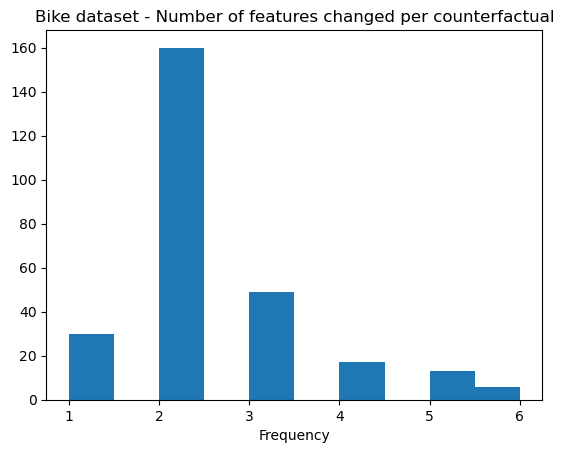

Smalelst number of features changed 1
Number of CFs with smallest number of features changed 30



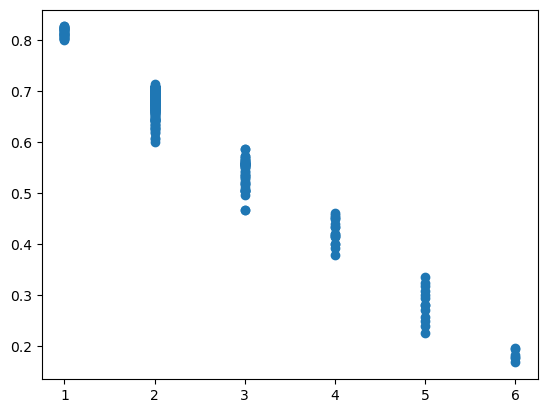

In [ ]:
#check number of fratures changed
import matplotlib.pyplot as plt
diff = counterfactuals != initial_instance
diff_per_cf = np.sum(diff.astype(int),axis=1)
plt.hist(diff_per_cf)
plt.xlabel("Number of fatures changed")
plt.xlabel("Frequency")
plt.title("Bike dataset - Number of features changed per counterfactual")
plt.show()
print('Smalelst number of features changed',np.min(diff_per_cf))
print('Number of CFs with smallest number of features changed',sum(diff_per_cf ==np.min(diff_per_cf)))
print()

plt.scatter(diff_per_cf,scores)
plt.show()

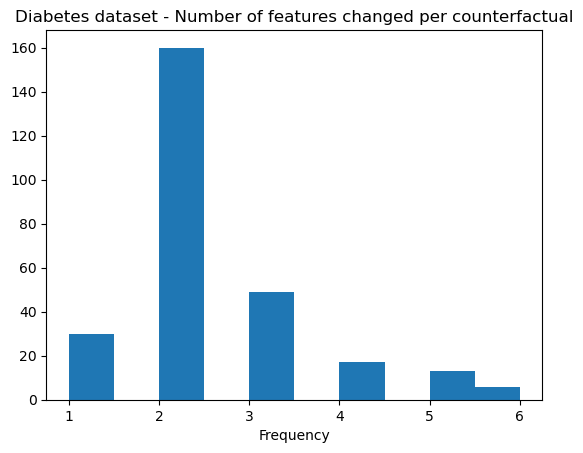

Smalelst number of features changed 1
Number of CFs with smallest number of features changed 30



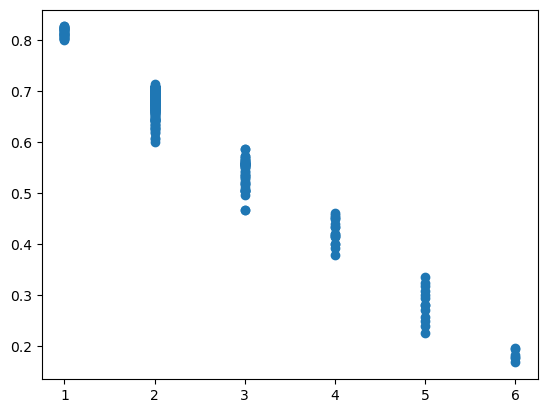

In [ ]:
#check number of fratures changed
import matplotlib.pyplot as plt
diff = counterfactuals != initial_instance
diff_per_cf = np.sum(diff.astype(int),axis=1)
plt.hist(diff_per_cf)
plt.xlabel("Number of fatures changed")
plt.xlabel("Frequency")
plt.title("Diabetes dataset - Number of features changed per counterfactual")
plt.show()
print('Smalelst number of features changed',np.min(diff_per_cf))
print('Number of CFs with smallest number of features changed',sum(diff_per_cf ==np.min(diff_per_cf)))
print()

plt.scatter(diff_per_cf,scores)
plt.show()

In [ ]:
counter_pred = predictions
pred_scores = surrogate.predict(ranker.prepare_x(counterfactuals))
counter_dist = score_calculator.gower_distance(initial_instance, counterfactuals)
counter_dist.shape,pred_scores.shape

((275,), (275,))

In [ ]:
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)
#sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(counter_dist,counter_pred, scores,c=scores, cmap=cm.coolwarm)
ax.set_ylabel('Y - Model output',labelpad=15)
ax.set_xlabel('X - Gower distance',labelpad=10)
ax.set_zlabel('Z - Optimization score')
ax.set_zlim(0,.85)
#ax.view_init(20, -120)
plt.show()

## Implementation with my dataset - Diabetes